In [1]:
import io
import nltk
import keras
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from keras.models import Sequential, Model, Input, load_model
from keras.layers import Embedding, Bidirectional, LSTM, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

sns.set(color_codes=True)

Using TensorFlow backend.


### Load fasttext embeddings

In [2]:
def load_vec(emb_path, nmax=None):
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        for i, line in enumerate(f):
            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')
            assert word not in word2id, 'word found twice'
            vectors.append(vect)
            word2id[word] = len(word2id)
            if nmax and len(word2id) == nmax:
                break
    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.vstack(vectors)
    return embeddings, id2word, word2id

In [3]:
embeddings, id2word, word2id = load_vec('../../aligned/wiki.en.align.vec')

### Load imdb dataset

In [4]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [5]:
train_df.head()

,text,rating,label
0,Yet another Die Hard straight to video rip off...,1,0
1,If you want to see a retarded homosexual Karat...,1,0
2,I saw this movie thinking that it would be one...,1,0
3,My siblings and I stumbled upon The Champions ...,7,1
4,This unpretentious Horror film is probably des...,9,1


### Prepare dataset

In [6]:
tokenizer = Tokenizer(filters="""!"'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n""")
tokenizer.fit_on_texts(list(word2id.keys()))

In [7]:
train_sequences = tokenizer.texts_to_sequences(train_df.text)
test_sequences = tokenizer.texts_to_sequences(test_df.text)

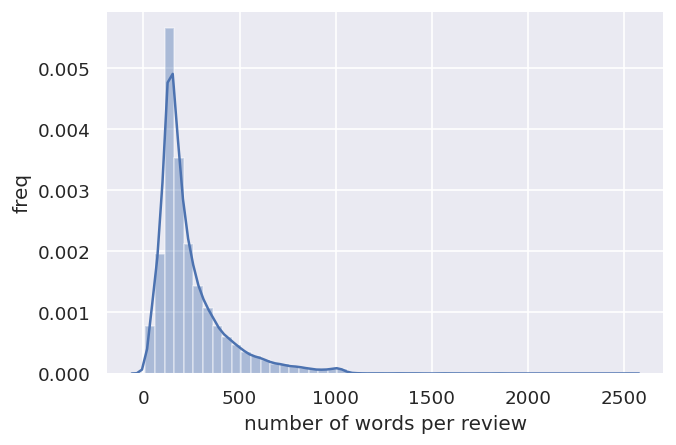

In [8]:
plt.figure(dpi=120)
plt.xlabel('number of words per review')
plt.ylabel('freq')
sns.distplot([len(s) for s in train_sequences])

In [9]:
maxlen = 1000

X_train = pad_sequences(train_sequences, maxlen=maxlen, truncating='post')
X_test = pad_sequences(test_sequences, maxlen=maxlen, truncating='post')

In [10]:
y_train = train_df.label.values
y_test = test_df.label.values

In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

### Train model

In [12]:
embeddings_ndarray = np.zeros((embeddings.shape[0] + 1, embeddings.shape[1]))
embeddings_ndarray[1:] = embeddings

In [13]:
inp = Input(shape=(maxlen,))
x = Embedding(embeddings_ndarray.shape[0], embeddings_ndarray.shape[1], weights=[embeddings_ndarray], trainable=False)(inp)
x = Bidirectional(LSTM(128, return_sequences=True))(x)
avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
conc = concatenate([avg_pool, max_pool])
conc = Dense(128, activation="relu")(conc)
conc = Dropout(0.2)(conc)
outp = Dense(1, activation="sigmoid")(conc)
model = Model(inputs=inp, outputs=outp)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
model_name = "imdb.model"
callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=3, mode='min'),
    ModelCheckpoint(model_name, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
]
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size=50, callbacks=callbacks_list)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 518s 26ms/step - loss: 0.6016 - accuracy: 0.6471 - val_loss: 0.4531 - val_accuracy: 0.7884

Epoch 00001: val_loss improved from inf to 0.45307, saving model to imdb.model
Epoch 2/10
20000/20000 [==============================] - 516s 26ms/step - loss: 0.3861 - accuracy: 0.8281 - val_loss: 0.3673 - val_accuracy: 0.8374

Epoch 00002: val_loss improved from 0.45307 to 0.36726, saving model to imdb.model
Epoch 3/10
20000/20000 [==============================] - 514s 26ms/step - loss: 0.2905 - accuracy: 0.8771 - val_loss: 0.3212 - val_accuracy: 0.8602

Epoch 00003: val_loss improved from 0.36726 to 0.32117, saving model to imdb.model
Epoch 4/10
20000/20000 [==============================] - 515s 26ms/step - loss: 0.2190 - accuracy: 0.9135 - val_loss: 0.3076 - val_accuracy: 0.8688

Epoch 00004: val_loss improved from 0.32117 to 0.30760, saving model to imdb.model
Epoch 5/10
20000/20000 

### Evaluate test set

In [12]:
model = load_model('imdb.model')

In [13]:
y_test_pred = model.predict(X_test, verbose=1)

25000/25000 [==============================] - 203s 8ms/step


In [14]:
accuracy_score(y_test, np.round(y_test_pred.squeeze()).astype(np.int32))

0.86728